# SCIPY

This notebook shows how to use curve_fit a task of scipy.




#scipy

In [2]:
# Hide warnings
import warnings
warnings.catch_warnings()
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines
from matplotlib.lines import Line2D  
from astropy.io import fits
from astropy.table import Table
import scipy
from scipy import optimize as op
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import axes3d
from numpy import arange

# import DPACP-93 utilities
from gspfig import plot_filter_comparison, FilterSpec, medsigline 
from gspfig import gspstyle
#
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch


For this tutorial we will use some SDSS data provided by Michele:

In [3]:
ff1 ='Y6A1_finsel_DR3_wXPSP.fits'

`ff1` contains the standardised synthetic photometry whereas `ff2` contains the non-standardised synthetic photometry. We will now load the two files using Astropy and convert them into [Pandas](https://pandas.pydata.org) dataframes:

In [4]:
%%time
df1 = Table.read(ff1).to_pandas()
df1.columns

CPU times: user 1.14 s, sys: 494 ms, total: 1.63 s
Wall time: 1.79 s


Index(['FGCM_ID', 'RA', 'DEC', 'FLAG', 'MAG_STD_G', 'MAG_STD_R', 'MAG_STD_I',
       'MAG_STD_Z', 'MAG_STD_Y', 'MAGERR_STD_G', 'MAGERR_STD_R',
       'MAGERR_STD_I', 'MAGERR_STD_Z', 'MAGERR_STD_Y', 'NGOOD_G', 'NGOOD_R',
       'NGOOD_I', 'NGOOD_Z', 'NGOOD_Y', 'source_id_1', 'RAdeg', 'DEdeg', 'Plx',
       'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'RUWE', 'G', 'e_G', 'BP',
       'e_BP', 'RP', 'e_RP', 'NBPcont', 'NBPblend', 'NRPcont', 'NRPblend',
       'AG', 'E(BP-RP)', 'phot_bp_rp_excess_factor', 'phot_variable_flag',
       'in_qso_candidates', 'in_galaxy_candidates', 'non_single_star',
       'C_star', 'Decam_mag_g', 'Decam_mag_r', 'Decam_mag_i', 'Decam_mag_z',
       'Decam_mag_Y', 'Decam_flux_g', 'Decam_flux_r', 'Decam_flux_i',
       'Decam_flux_z', 'Decam_flux_Y', 'Decam_flux_error_g',
       'Decam_flux_error_r', 'Decam_flux_error_i', 'Decam_flux_error_z',
       'Decam_flux_error_Y'],
      dtype='object')

We want to have all the information in a single dataframe: this can be easily achieved by joining the two dataframes by the `source_id` column. Since both files have several columns in common, we remove them from the second dataframe and then rename the unique columns to avoid confusion:

In [5]:
df1.rename(columns={
    'MAG_STD_G': 'g_ref',
    'MAG_STD_R': 'r_ref',
    'MAG_STD_I': 'i_ref',
    'MAG_STD_Z': 'z_ref',
    'MAG_STD_Y': 'y_ref',
    'Decam_mag_g': 'g_std',
    'Decam_mag_r': 'r_std',
    'Decam_mag_i': 'i_std',
    'Decam_mag_z': 'z_std',
    'Decam_mag_Y': 'y_std',
}, inplace=True)


dfms = df1

The `dfm` dataframe now contains both the standardised and non-standardised photometry:

In [6]:
dfms.columns

Index(['FGCM_ID', 'RA', 'DEC', 'FLAG', 'g_ref', 'r_ref', 'i_ref', 'z_ref',
       'y_ref', 'MAGERR_STD_G', 'MAGERR_STD_R', 'MAGERR_STD_I', 'MAGERR_STD_Z',
       'MAGERR_STD_Y', 'NGOOD_G', 'NGOOD_R', 'NGOOD_I', 'NGOOD_Z', 'NGOOD_Y',
       'source_id_1', 'RAdeg', 'DEdeg', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA',
       'pmDE', 'e_pmDE', 'RUWE', 'G', 'e_G', 'BP', 'e_BP', 'RP', 'e_RP',
       'NBPcont', 'NBPblend', 'NRPcont', 'NRPblend', 'AG', 'E(BP-RP)',
       'phot_bp_rp_excess_factor', 'phot_variable_flag', 'in_qso_candidates',
       'in_galaxy_candidates', 'non_single_star', 'C_star', 'g_std', 'r_std',
       'i_std', 'z_std', 'y_std', 'Decam_flux_g', 'Decam_flux_r',
       'Decam_flux_i', 'Decam_flux_z', 'Decam_flux_Y', 'Decam_flux_error_g',
       'Decam_flux_error_r', 'Decam_flux_error_i', 'Decam_flux_error_z',
       'Decam_flux_error_Y'],
      dtype='object')

In [7]:
%%time
filts = ['g', 'r', 'i', 'z', 'y']
for fname in filts:
    dfms[f'delta{fname}_std'] = dfms[f'{fname}_ref'] - dfms[f'{fname}_std']

CPU times: user 18.6 ms, sys: 1.46 ms, total: 20.1 ms
Wall time: 17.5 ms


In [8]:
dfsel = dfms[(dfms['G'] <= 17.65) & (dfms['BP'] <99) & (dfms['RP']  < 99)]
print(f'Full dataset: {len(dfms)}, subset: {len(dfsel)}')
dfsel['bp_rp']=dfsel['BP']-dfsel['RP']
dfsel.columns
dfms=dfsel


Full dataset: 755821, subset: 754142


In [9]:
# define the true objective function
def objective(x, a,  f):
 return (a * x)    + f

def objective4(x, a, b, c,d, f):
 return (a * x) + (b * x**2) + (c * x**3)  + + (c * x**4)+f

def residuals(x, a, f, y):     #for least square
    e=x*0+1.
    return (y-objective(x, a,  f)) / e

def residuals4(x, a, b, c,d, f, y):     #for least square
    e=x*0+1.
    return (y-objective4(x, a, b, c,d, f)) / e

def chisq(x, a,   y):
    return (residuals(x, a, y)**2).sum()

def chisq4(x, a, b, c, d, f,y):
    return (residuals4(x, a, b, c,d, f,y)**2).sum()

def get_fit(xi2,zi2,x_line):
  popt, pcov = curve_fit(objective, xi2, zi2) 
  a,    f = popt
  y_line = objective(x_line, a,    f)
  yf=objective(xi2, a,   f)
  #e=xi2*0+1.
  resid=residuals(xi2, a,    f,zi2)
  stand=resid.std()
  #aa=yf-zi2
  #stand2=aa.std()
  #chi2=chisq(xi2, a, b, c,  f,zi2)
  #print(popt)
  #print(np.sqrt(np.diag(pcov)))
  return { 'Yfit': yf, 'y_line': y_line, 'std':stand}

def get_fit4(xi2,zi2,x_line):
  popt, pcov = curve_fit(objective4, xi2, zi2) 
  a, b, c, d, f = popt
  y_line = objective4(x_line, a, b, c,d,  f)
  yf=objective4(xi2, a, b, c,d,  f)
  resid=residuals(xi2, a, b, c,  f,zi2)
  stand=resid.std()
  return { 'Yfit': yf, 'y_line': y_line, 'std':stand}

def get_plot(xi2,zi2,yf,x_line, y_line,xtitle,ytitle):
  fig = plt.figure() 
  ax = fig.add_subplot(111) 
  ax.scatter(xi2, yf, color='cyan') 
  ax.scatter(xi2, zi2, color='pink') 
  ax.set_xlabel(xtitle) 
  ax.set_ylabel(ytitle) 
  ax.scatter(x_line, y_line, color='r') 
  plt.show()



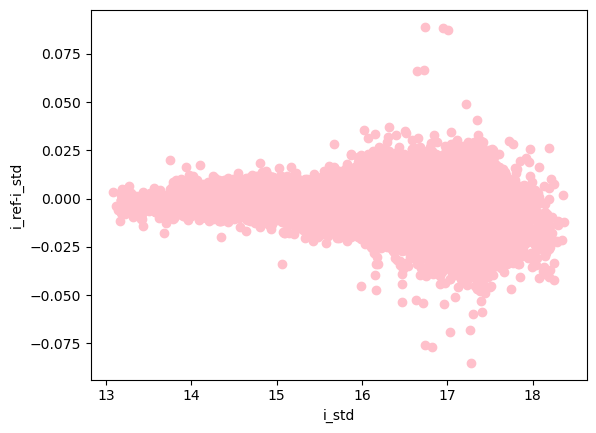

In [10]:
dfsel2 = dfsel[(dfsel['i_ref']-dfsel['i_std'] <= 0.4)]

xi2=dfsel2['i_ref']
zi2=dfsel2['i_ref']-dfsel2['i_std']
xi2=np.array(xi2)
zi2=np.array(zi2)
fig = plt.figure() 
ax = fig.add_subplot(111) 
ax.scatter(xi2, zi2, color='pink') 
ax.set_xlabel('i_std') 
ax.set_ylabel('i_ref-i_std') 
plt.show()


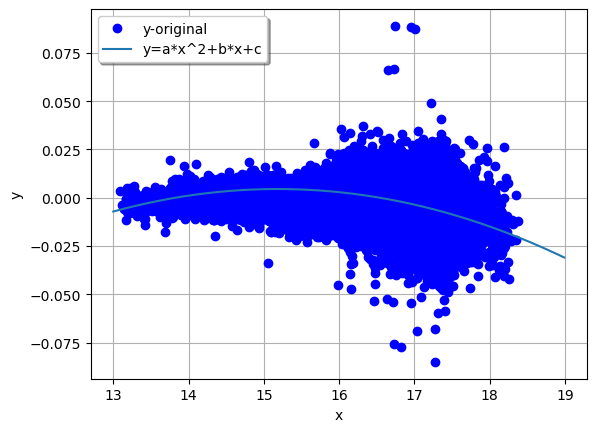

In [13]:
def func1(x, a, b, c):
    return a*x**2+b*x+c

def func2(x, a, b, c):
    return a*x**3+b*x+c

def func3(x, a, b, c):
    return a*x**3+b*x**2+c

def func4(x, a, b, c):
    return a*exp(b*x)+c 

params, covs = curve_fit(func1, xi2, zi2)
a, b, c = params[0], params[1], params[2]
yfit1 = a*xi2**2+b*xi2+c
x_line = arange(13., 19., 0.01)
y_line=a*x_line**2+b*x_line+c

plt.plot(xi2, zi2, 'bo', label="y-original")
plt.plot(x_line, y_line, label="y=a*x^2+b*x+c")
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show() 



